**BI Project - Boston Airbnb**

#Buisness case and KPIs

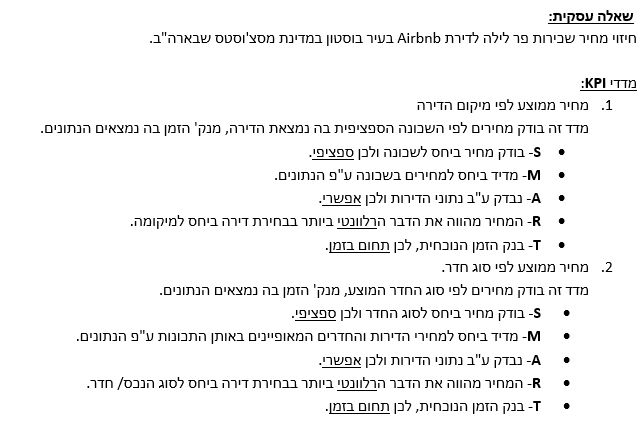

#Data Warehouse

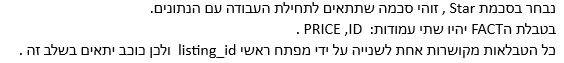

**ERD**


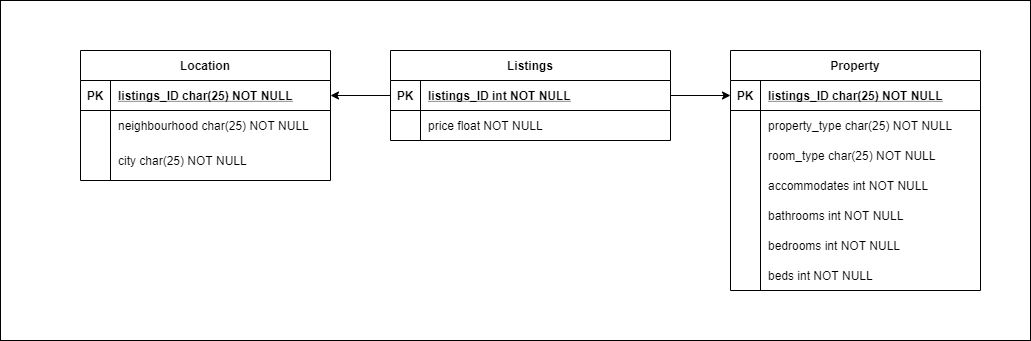

**USECASE**


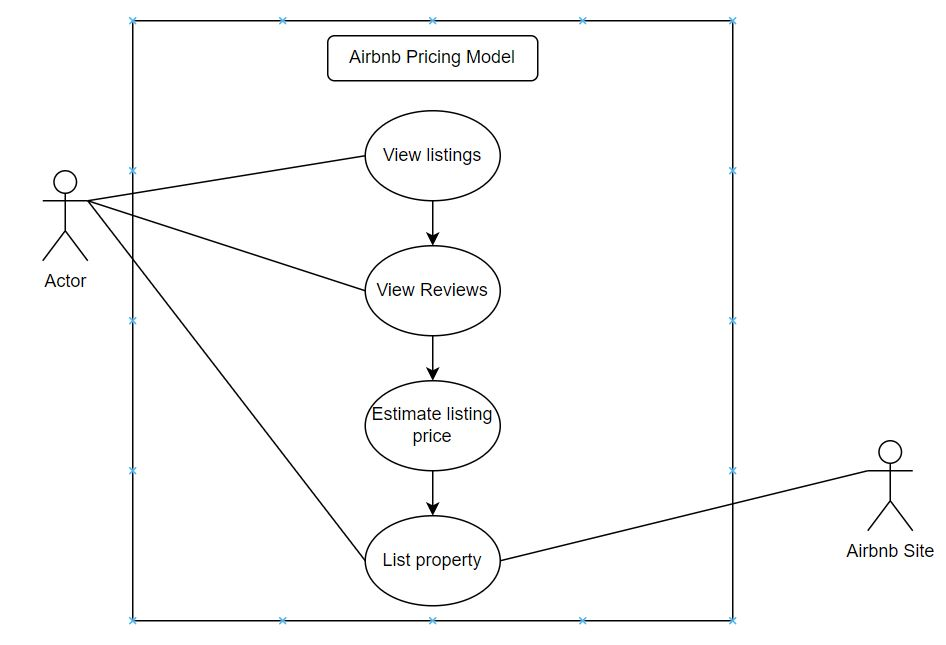

#הגדרה ומימוש ETL

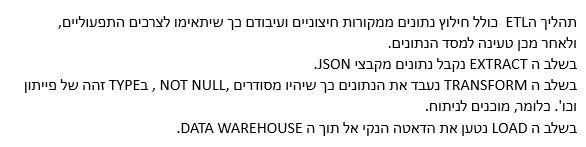

#Data

In [ ]:
!pip install jsonpath_ng

In [ ]:
Requirement already satisfied: jsonpath_ng in /usr/local/lib/python3.10/dist-packages (1.5.3)
Requirement already satisfied: ply in /usr/local/lib/python3.10/dist-packages (from jsonpath_ng) (3.11)
Requirement already satisfied: decorator in /usr/local/lib/python3.10/dist-packages (from jsonpath_ng) (4.4.2)
Requirement already satisfied: six in /usr/local/lib/python3.10/dist-packages (from jsonpath_ng) (1.16.0)

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import sqlite3
import functools as ft
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from jsonpath_ng import parse
from enum import Enum
%matplotlib inline

In [ ]:
with open("listings.json", "r") as file:
    data = json.load(file)
    for item in data:
      item["id"] = str(item["id"])
      #item["bathrooms"] = float(item["bathrooms"])
      #item["bedrooms"] = int(item["bedrooms"])
      #item["beds"] = float(item["beds"])


data[:2]

[{'id': '12147973',
  'listing_url': 'https://www.airbnb.com/rooms/12147973',
  'scrape_id': 20200000000000,
  'last_scraped': '07/09/2016',
  'name': 'Sunny Bungalow in the City',
  'summary': 'Cozy, sunny, family home.  Master bedroom high ceilings. Deck, garden with hens, beehives & play structure.   Short walk to charming village with  attractive stores, groceries & local restaurants. Friendly neighborhood. Access public transportation.',
  'space': 'The house has an open and cozy feel at the same time.  The living room has a flat screen TV.  The kitchen has all you need for cooking.  We prefer you buy your food but can use the organic oils, herbs, etc.   The yard can be seen from sitting room and when the weather allows, the yard is a place children can lose themselves in a safe way.  We have 2 bee hives, 6 hens fenced in (sometimes they get out of their coop area & into the yard), 2 rabbits in a hutch and play structure.',
  'description': "Cozy, sunny, family home.  Master bedro

###  Abstract Base Calss (ABC) for mutual methods

In [ ]:
class Interface(ABC):

    @abstractmethod
    def get_data_by_field(self, field_name):
        """Fetch the data by given feild name """

    @abstractmethod
    def get_data_by_id(self, id):
        """Fetch the data by given ID  """

    @abstractmethod
    def get(self):
        """Fetch all data """

### Transform Operations
inherithed from Enum - class that automatic enumrate the variables

In [ ]:
class TransformMask(Enum):
    # add here any masks you want
    CLEAN_STRING = ".strip().lower()"
    CAPITAL_LETTER = ".strip().lower().title()"
    CLEAN_NUM = ""


### Database Class - Define Common Properties for Source, Target, Mapping

In [ ]:
class Database:
    def __init__(self):
        self.db = {
            "source": [],
            "destination": [],
            "transform": [],
            "mapping": []
        }
        #Fact
        #id
        self.add_source(1, "id", "str")
        self.add_destination(1, "id", "str", "fact")
        self.add_transform(1, "CLEAN_STRING")
        self.add_mapping(1, 1, 1, 1, "fact")
        #price
        self.add_source(2, "price", "int")
        self.add_destination(2, "price", "float", "fact")
        self.add_transform(2, "CLEAN_NUM")
        self.add_mapping(2, 2, 2, 2, "fact")
        #dim_property
        #city
        self.add_source(3, "city", "str")
        self.add_destination(3, "city", "str", "dim_location")
        self.add_transform(3, "CLEAN_STRING")
        self.add_mapping(3, 3, 3, 3, "dim_property")
        #neighbourhood
        self.add_source(4, "neighbourhood", "str")
        self.add_destination(4, "neighbourhood", "str", "dim_location")
        self.add_transform(4, "CLEAN_STRING")
        self.add_mapping(4, 4, 4, 4, "dim_property")
        #property_type
        self.add_source(5, "property_type", "str")
        self.add_destination(5, "property_type", "str", "dim_property")
        self.add_transform(5, "CLEAN_STRING")
        self.add_mapping(5, 5, 5, 5, "dim_property")
        #room_type
        self.add_source(6, "room_type", "str")
        self.add_destination(6, "room_type", "str", "dim_property")
        self.add_transform(6, "CLEAN_STRING")
        self.add_mapping(6, 6, 6, 6, "dim_property")
        #accommodates
        self.add_source(7, "accommodates", "int")
        self.add_destination(7, "accommodates", "int", "dim_property")
        self.add_transform(7, "CLEAN_NUM")
        self.add_mapping(7, 7, 7, 7, "dim_property")
        #bathrooms
        self.add_source(8, "bathrooms", "int")
        self.add_destination(8, "bathrooms", "int", "dim_property")
        self.add_transform(8, "CLEAN_NUM")
        self.add_mapping(8, 8, 8, 8, "dim_property")
        #bedrooms
        self.add_source(9, "bedrooms", "int")
        self.add_destination(9, "bedrooms", "int", "dim_property")
        self.add_transform(9, "CLEAN_NUM")
        self.add_mapping(9, 9, 9, 9, "dim_property")
        #beds
        self.add_source(10, "beds", "int")
        self.add_destination(10, "beds", "int", "dim_property")
        self.add_transform(10, "CLEAN_NUM")
        self.add_mapping(10, 10, 10, 10, "dim_property")

    def add_source(self, id, field, typ):
            self.db["source"].append({
                "id": id,
                "source_field_name": field,
                "source_field_mapping": field,
                "source_field_type": typ,
                "is_required": True,
            })

    def add_destination(self, id, field, typ, destination):
        self.db["destination"].append({
            "id": id,
            "destination_field_name": field,
            "destination_field_mapping": field,
            "destination_field_type": typ,
            "default_value": "n/a",
            "destination_table": destination,
        })

    def add_transform(self, id, mask):
        self.db["transform"].append({
            "id": id,
            "transform_mask": mask,
        })

    def add_mapping(self, id, source, dest, transform, destination):
      self.db["mapping"].append({
          "id": id,
          "mapping_source": source,
          "mapping_destination": dest,
          "mapping_transform": transform,
          "destination_table": destination,
        })


    @property
    def get_data_source_target_mapping(self):
      return self.db


### Source class

Inherited from Interface for the common methods and from Database for common variables

In [ ]:
class Source(Interface, Database):
    def __init__(self):
        Database.__init__(self)

    # should be implemented - inherited from Interface
    def get_data_by_field(self, field_name):
        data = self.get
        for item in data:
            for key, value in item.items():
                if key == field_name:
                    return item
        return None

    @property
    def get(self):
        return self.get_data_source_target_mapping.get("source")

    def get_data_by_id(self, id):
        self.id = id
        data = self.get
        for x in data:
            if x.get("id") == self.id:
                return x
        return None

### Target class

Inherited from Interface for the common methods and from Database for common variables

In [ ]:
class Target(Interface, Database):

    def __init__(self):
        Database.__init__(self)

    # should be implemented - inherited from Interface
    def get_data_by_field(self, field_name):
        data = self.get
        for item in data:
            for key, value in item.items():
                if key == field_name:
                    return item
        return None

    @property
    def get(self):
        return self.get_data_source_target_mapping.get("destination")

    def get_data_by_id(self, id):
        self.id = id
        data = self.get
        for x in data:
            if x.get("id").__str__() == self.id.__str__():
                return x
        return None

### Transform Class

Inherited from Interface for the common methods and from Database for common variables

In [ ]:
class Transform(Interface, Database):

    def __init__(self):
        Database.__init__(self)

    # should be implemented - inherited from Interface
    def get_data_by_field(self, field_name):
        data = self.get
        for item in data:
            for key, value in item.items():
                if key == field_name:
                    return item
        return None

    @property
    def get(self):
        return self.get_data_source_target_mapping.get("transform", [])

    def get_data_by_id(self, id):
        self.id = id
        data = self.get
        for x in data:
            if x.get("id").__str__() == self.id.__str__():
                return x
        return None

### Mapping class

Inherited from Interface for the common methods and from Database for common variables

In [ ]:
class Mappings(Interface, Database):

    def __init__(self):
        Database.__init__(self)

    @property
    def get(self):
        return self.get_data_source_target_mapping.get("mapping")

    def get_data_by_id(self, id):
        self.id = id
        data = self.get
        for x in data:
            if x.get("id").__str__() == self.id.__str__():
                return x
        return None

    def get_data_by_field(self, field_name):
        return None

### Format Class - JSON

Search the source data value inside a JSON file

In [ ]:
class JsonQuery:
    def __init__(self, json_path, json_data):
        self.json_path = json_path
        self.json_data = json_data

    def get(self):
        jsonpath_expression = parse(self.json_path)
        match = jsonpath_expression.find(self.json_data)
        source_data_value = match[0].value
        return source_data_value

### Combine it All - STTM

In [ ]:
class STTM:
    def __init__(self, input_json):
        self.input_json = input_json
        self.mapping_instance = Mappings()
        self.source_instance = Source()
        self.destination_instance = Target()
        self.transform_instance = Transform()
        self.look_up_mask = {i.name: i.value for i in TransformMask}
        self.json_data_transformed = {}
        self.to_table = {}

    def _get_mapping_data(self):
        return self.mapping_instance.get

    def _get_mapping_source_data(self):
        return self.source_instance.get

    def get_transformed_data(self):

        for mappings in self._get_mapping_data():

            """fetch the source mapping """
            mapping_source_id = mappings.get("mapping_source")
            mapping_destination_id = mappings.get("mapping_destination")
            mapping_transform_id = mappings.get("mapping_transform")
            mapping_table = mappings.get("destination_table")

            mapping_source_data = self.source_instance.get_data_by_id(id=mapping_source_id)
            transform_data = self.transform_instance.get_data_by_id(id=mapping_transform_id)

            """Fetch Source  field Name"""
            source_field_name = mapping_source_data.get("source_field_name")

            """if field given is not present incoming json """
            if source_field_name not in self.input_json.keys():
                if mapping_source_data.get("is_required"):
                    raise Exception(
                        "Alert ! Field {} is not present in JSON please FIX mappings ".format(source_field_name))
                else:
                    pass

            else:
                source_data_value = JsonQuery(
                    json_path=mapping_source_data.get("source_field_mapping"),
                    json_data=self.input_json
                ).get()

                """check the data type for source if matches with what we have """
                if mapping_source_data.get("source_field_type") != type(source_data_value).__name__:
                    if source_data_value is not None:
                        _message = (
                            "Alert ! Source Field :{} Datatype has changed from {} to {} ".format(source_field_name,
                                                                                                  mapping_source_data.get(
                                                                                                      "source_field_type"),
                                                                                                  type(
                                                                                                      source_data_value).__name__))
                        print(_message)
                        raise Exception(_message)

                """Query and fetch the Destination | target """
                destination_mappings_json_object = self.destination_instance.get_data_by_id(
                    id=mappings.get("mapping_destination"))

                destination_field_name = destination_mappings_json_object.get("destination_field_name")
                destination_field_type = destination_mappings_json_object.get("destination_field_type")
                self.to_table[destination_field_name] = mapping_table

                dtypes = [str, float, list, int, set, dict]

                for dtype in dtypes:

                    """Datatype Conversion """
                    if destination_field_type == str(dtype.__name__):

                        """is source is none insert default value"""
                        if source_data_value is None: #(לבדוק שינוי זה)
                        #if source_data_value is None or source_data_value == 'n/a':
                            self.json_data_transformed[destination_field_name] = dtype.__call__(
                                destination_mappings_json_object.get("default_value")
                            )

                        else:
                            """check if you have items to transform"""
                            if transform_data is not None:
                                """ check for invalid mask name """
                                if transform_data.get("transform_mask") not in list(self.look_up_mask.keys()):
                                    raise Exception(
                                        f"Specified Transform {transform_data.get('transform_mask')} is not available please select from following Options :{list(self.look_up_mask.keys())}")
                                else:
                                    mask_apply = self.look_up_mask.get(transform_data.get("transform_mask"))
                                    converted_dtype = dtype.__call__(source_data_value)
                                    mask = f'converted_dtype{mask_apply}'
                                    curated_value = eval(mask)
                                    self.json_data_transformed[destination_field_name] = curated_value

                            else:
                                self.json_data_transformed[destination_field_name] = dtype.__call__(source_data_value)

        return self.json_data_transformed, self.to_table

In [ ]:
transformed_data = []
for item in data:
    helper = STTM(input_json=item)
    response, mapping = helper.get_transformed_data()
    transformed_data.append(response)
    print(response)
print(mapping)

{'id': '12147973', 'price': 250.0, 'city': 'boston', 'neighbourhood': 'roslindale', 'property_type': 'house', 'room_type': 'entire home/apt', 'accommodates': 4, 'bathrooms': 1, 'bedrooms': 2, 'beds': 3}
{'id': '3075044', 'price': 65.0, 'city': 'boston', 'neighbourhood': 'roslindale', 'property_type': 'apartment', 'room_type': 'private room', 'accommodates': 2, 'bathrooms': 1, 'bedrooms': 1, 'beds': 1}
{'id': '6976', 'price': 65.0, 'city': 'boston', 'neighbourhood': 'roslindale', 'property_type': 'apartment', 'room_type': 'private room', 'accommodates': 2, 'bathrooms': 1, 'bedrooms': 1, 'beds': 1}
{'id': '1436513', 'price': 75.0, 'city': 'boston', 'neighbourhood': '', 'property_type': 'house', 'room_type': 'private room', 'accommodates': 4, 'bathrooms': 1, 'bedrooms': 1, 'beds': 2}
{'id': '7651065', 'price': 79.0, 'city': 'boston', 'neighbourhood': 'roslindale', 'property_type': 'house', 'room_type': 'private room', 'accommodates': 2, 'bathrooms': 1, 'bedrooms': 1, 'beds': 2}
{'id': '12

In [ ]:
pd.DataFrame(transformed_data)

,id,price,city,neighbourhood,property_type,room_type,accommodates,bathrooms,bedrooms,beds
0,12147973,250.0,boston,roslindale,house,entire home/apt,4,1,2,3
1,3075044,65.0,boston,roslindale,apartment,private room,2,1,1,1
2,6976,65.0,boston,roslindale,apartment,private room,2,1,1,1
3,1436513,75.0,boston,,house,private room,4,1,1,2
4,7651065,79.0,boston,roslindale,house,private room,2,1,1,2
...,...,...,...,...,...,...,...,...,...,...
3580,8373729,69.0,somerville,somerville,apartment,private room,3,1,1,1
3581,14844274,150.0,brookline,,apartment,private room,2,1,1,1
3582,14585486,198.0,cambridge,,apartment,entire home/apt,4,1,1,1
3583,14603878,65.0,somerville,somerville,apartment,private room,2,1,1,1


In [ ]:
import pandas as pd

# Assuming transformed_data is a list
transformed_data = pd.DataFrame(transformed_data)  # Convert list to DataFrame

transformed_data.to_csv('output.csv', index=False)  # Export DataFrame to CSV

Attached FILE CSV = output

```



# Data Warehouse Analysis

In [ ]:
SELECT neighbourhood, AVG(price) OVER (PARTITION BY neighbourhood) AS "price_avg_neighbrhd"
FROM location, fact
WHERE location.id = fact.id
GROUP by neighbourhood
order by 2 DESC;
/********/

SELECT accommodates, bedrooms, bathrooms,  AVG(price) OVER (PARTITION BY bathrooms,bedrooms, accommodates) AS "price_avg_bb"
FROM property, fact
WHERE property.id = fact.id
GROUP by bathrooms, bedrooms, accommodates
order by 3, 2, 1 DESC;
/*********/

SELECT neighbourhood, property_type, count(*) as "num of properties" , AVG(price) OVER (PARTITION BY neighbourhood, property_type) as "price_avg_np"
FROM location, property, fact
WHERE property.id = fact.id
AND location.id = fact.id
GROUP by 1,2
order by 1, 2,3 desc;
/*********/

select AVG(accommodates), neighbourhood,  AVG(price) OVER (PARTITION BY accommodates, neighbourhood) AS "price_avg_an"
FROM location, property, fact
WHERE property.id = fact.id
AND location.id = fact.id
GROUP by 2
order by 1,2 DESC;
/*********/

SELECT cancellation_policy,  AVG(price) OVER (PARTITION BY cancellation_policy) AS "price_avg_cp"
FROM property , fact
WHERE property.id = fact.id
GROUP by 1
order by 1 DESC;
/*********/

SELECT  neighbourhood, property_type,  (AVG(price) OVER (PARTITION BY accommodates, property_type)) / avg(accommodates)  AS "price_avg per person"
FROM location, property, fact
WHERE property.id = fact.id
AND location.id = fact.id
GROUP by 1,2
order by 1 DESC;
/*********/

SELECT neighbourhood, property_type, MAX(price) OVER (PARTITION BY neighbourhood, property_type) AS 'MAX_PRICE',
MIN(price) OVER (PARTITION BY neighbourhood, property_type) AS 'MIN_PRICE'
FROM location, property, fact
WHERE property.id = fact.id
AND location.id = fact.id
GROUP BY 1,2
ORDER BY 1,2;
/*********/

SELECT neighbourhood, room_type,  AVG(price) OVER (PARTITION BY neighbourhood, room_type) AS "price_avg_nr"
FROM location, property, fact
WHERE property.id = fact.id
AND location.id = fact.id
GROUP by 1,2
order by 1,2 DESC;
/*********/

#Conclusions

1. The average prices vary across different neighborhoods, indicating that location plays a significant role in determining property prices.

2. The average prices differ based on the combination of accommodation details such as the number of bedrooms, bathrooms, and the capacity to accommodate guests.

3. The average price differs based on the cancellation policy, implying that the flexibility of cancellation policies may influence property prices.

4. The average price per person varies across neighborhoods and property types, indicating that the cost of accommodation per person can differ based on the specific location and property type.


Overall, these queries allow us to have insights into the average prices, price variations, and other statistical information related to different criteria such as neighborhood, accommodation details, property type, cancellation policy, and room type. They help in understanding the pricing dynamics within a given dataset and can assist in making informed decisions related to property investments, pricing strategies, and customer preferences.
